In [36]:
import os
import albumentations as albu
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.models import resnet50
import mlflow
from catalyst import dl, utils, metrics
from catalyst.contrib.layers import ArcFace
from catalyst.loggers.mlflow import MLflowLogger
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
batch_size = 64
val_batch_size = 100
lr = 0.05
num_epochs = 20
early_stopping_epochs = 12
reduce_lr_patience = 3


In [5]:
priviledged_group = 'Male'
unpriviledged_group = 'Female'

In [6]:
experiment_mlflow = "bias_mitigation_v1"
logdir = 'experiments/face_modelv1'
only_male=False
distill_model=False  # 'experiments/face_modelv9'

In [ ]:
if distill_model:
    lr = 0.05
    num_epochs = 22
    experiment_mlflow = "bias_mitigation_v2"
    logdir = 'experiments/face_modelv2'
    only_male=False

In [7]:
train = pd.read_csv('face_age_gender.csv')
image_path = train['image_path'].values
targets = train['target'].values
gender_data = train['gender'].values


In [8]:
name2class = {name: idx for idx, name in enumerate(sorted(set(targets)))}
id_targets = np.array([name2class[target] for target in targets])
num_classes = len(name2class)

In [9]:
splitter = StratifiedShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(image_path, targets)
train_inds, val_inds = next(split)
train_images = image_path[train_inds]
val_images = image_path[val_inds]
train_targets = id_targets[train_inds]
val_targets = id_targets[val_inds]
train_gender_data = gender_data[train_inds]
val_gender_data = gender_data[val_inds]
if only_male:
    train_raw_targets = targets[train_inds]
    val_raw_targets = targets[val_inds]
    train_male_inds = np.where(train_gender_data=='Male')[0]
    train_images = train_images[train_male_inds]
    train_targets = train_targets[train_male_inds]
    train_gender_data = train_gender_data[train_male_inds] 
    val_male_inds = np.where(val_gender_data=='Male')[0]
    val_images = val_images[val_male_inds]
    val_targets = val_targets[val_male_inds]
    val_gender_data = val_gender_data[val_male_inds]

In [10]:
class ARCResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ARCResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        s=2**0.5*np.log(num_classes - 1)
        s=13
        self.model.fc = nn.Linear(self.model.fc.in_features, self.model.fc.in_features)
        self.head = ArcFace(self.model.fc.out_features, num_classes, s=s, m=0.15)

    def get_last_conv_features(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

    def special_forward(self, x, targets=None):
        model_features = self.get_last_conv_features(x)
        outputs = self.model.fc(model_features)
        outputs = self.head(outputs, targets)
        return outputs, model_features
    
    def forward(self, x, targets=None):
        outputs = self.model(x)
        outputs = self.head(outputs, targets)
        return outputs


In [11]:
device = torch.device("cuda")

In [38]:
distill_model

False

In [12]:
if distill_model:
    if os.path.exists('all_teacher_model_features.npy'):
        all_teacher_model_features = np.load('all_teacher_model_features.npy')
    else:
        teacher_model = ARCResNet50(num_classes=num_classes)
        state_dict = torch.load(os.path.join(distill_model, "model.last.pth"))
        teacher_model.load_state_dict(state_dict)
        teacher_model.to(device)
        cpu_device = torch.device('cpu')
        entire_dataset =  ImagesDataset(image_path, gender_data, targets=id_targets, transforms=get_transforms('valid'))
        entire_data_loader = DataLoader(entire_dataset, batch_size=val_batch_size, shuffle=False, num_workers=8)
        all_teacher_model_features = []
        for batch in tqdm_notebook(entire_data_loader):
            inputs, sensitive_attribute, targets = batch
            with torch.no_grad():
                outputs = teacher_model.get_last_conv_features(inputs.to(device)).to(cpu_device).numpy()
            all_teacher_model_features.append(outputs)
        del teacher_model
        all_teacher_model_features = np.vstack(all_teacher_model_features)
        np.save('all_teacher_model_features.npy', all_teacher_model_features)
    train_teacher_model_features = all_teacher_model_features[train_inds]
    val_teacher_model_features = all_teacher_model_features[val_inds]
model = ARCResNet50(num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=reduce_lr_patience, factor=0.1)

/home/dcek/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dcek/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
class ImagesDataset(Dataset):
    def __init__(self, files, sensitive_attributes, targets=None, transforms=None, teacher_model_features=None):
        self.files = files
        self.sensitive_attributes = sensitive_attributes
        self.targets = targets
        self.transforms = transforms
        self.teacher_model_features = teacher_model_features
        
    def __len__(self):
        return len(self.files)
 
    def __getitem__(self, index):
        file = self.files[index]
        img = np.array(Image.open(file))
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        if self.targets is None:
            return img

        target = self.targets[index]
        sensitive_attribute = self.sensitive_attributes[index]
        if self.teacher_model_features is None:
            return img, sensitive_attribute, target 
        else:
            teacher_model_feature = torch.from_numpy(self.teacher_model_features[index])
            return img, sensitive_attribute, target, teacher_model_feature

In [14]:
def get_transforms(dataset: str):
    if dataset.lower() == "train":
        return albu.Compose([
            albu.Resize(224, 224),
            albu.Normalize(),
            ToTensorV2()
        ])
    else:
        return albu.Compose([
            albu.Resize(224, 224),
            albu.Normalize(),
            ToTensorV2()
        ])


In [15]:
if distill_model:
    train_dataset = ImagesDataset(
        train_images,
        train_gender_data, 
        train_targets,
        get_transforms('train'),
        train_teacher_model_features,
    )
    val_dataset = ImagesDataset(
        val_images, 
        val_gender_data,
        val_targets, 
        get_transforms('valid'),
        val_teacher_model_features,
    )

else:
    train_dataset = ImagesDataset(train_images,train_gender_data, train_targets, get_transforms('train'))
    val_dataset = ImagesDataset(val_images, val_gender_data, val_targets, get_transforms('valid'))

loaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8),
    "valid": DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=8)
}

In [16]:
def compute_classwise_stats(y_pred, y_true):
    unique_classes = np.unique(y_true)
    num_classes = len(unique_classes)
    false_positives = np.zeros(num_classes)
    total_negatives = np.zeros(num_classes)
    true_positives = np.zeros(num_classes)
    total_positives = np.zeros(num_classes)

    for c_idx in range(num_classes):
        class_label = unique_classes[c_idx]
        class_predictions = (y_pred == class_label)
        class_labels = (y_true == class_label)
        false_positives[c_idx] = np.sum(class_predictions & ~class_labels)
        total_negatives[c_idx] = np.sum(~class_labels)
        true_positives[c_idx] = np.sum(class_predictions & class_labels)
        total_positives[c_idx] = np.sum(class_labels)
    return {
        "false_positives":false_positives,
        "total_negatives": total_negatives,
        "true_positives": true_positives,
        "total_positives": total_positives,
        "total": total_negatives + total_positives,
    }

def safe_division(a, b):
    return a/b if b else 0.0


In [17]:
def compute_multiclass_fairness_metrics(
    y_pred, y_true, sensitive_attribute, priviledged_group, unpriviledged_group
):
    y_pred = y_pred.argmax(1)
    group_stats = {}
    for group in [priviledged_group, unpriviledged_group]:
        group_idx = sensitive_attribute == group
        group_stats[group] = compute_classwise_stats(
        y_pred[group_idx], y_true[group_idx])
        
    disparities = []
    priviledged_true_positive_ratio = safe_division(
        np.sum(group_stats[priviledged_group]["true_positives"]),
        np.sum(group_stats[unpriviledged_group]["total"])
    )
    unpriviledged_true_positive_ratio = safe_division(
        np.sum(group_stats[unpriviledged_group]["true_positives"]),
        np.sum(group_stats[unpriviledged_group]["total"])
    )
    disparate_impact = safe_division(unpriviledged_true_positive_ratio, priviledged_true_positive_ratio)
    statistical_parity_diff = priviledged_true_positive_ratio - unpriviledged_true_positive_ratio
    
    for group in [priviledged_group, unpriviledged_group]:
        group_stats[group]["fpr"] = safe_division(
            np.sum(group_stats[priviledged_group]["false_positives"]),
            np.sum(group_stats[priviledged_group]["total_negatives"])
        )
        group_stats[group]["tpr"] = safe_division(
            np.sum(group_stats[priviledged_group]["true_positives"]),
            np.sum(group_stats[priviledged_group]["total_positives"])
        )
    AOD = (
        (group_stats[unpriviledged_group]["fpr"] - group_stats[priviledged_group]["fpr"])
        + (group_stats[unpriviledged_group]["tpr"] - group_stats[priviledged_group]["fpr"])
    ) / 2
    AAOD = (
        np.abs(group_stats[unpriviledged_group]["fpr"] - group_stats[priviledged_group]["fpr"])
        + np.abs(group_stats[unpriviledged_group]["tpr"] - group_stats[priviledged_group]["fpr"])
    ) / 2
 
    return {
        "disparate_impact": disparate_impact,
        "statistical_parity_diff": statistical_parity_diff,
        "average_odds_diff": AOD,
        "average_abs_odds_diff": AAOD
    }

                            




In [18]:
mlflow_params = dict(
    batch_size=batch_size,
    lr=lr,
    num_epochs=num_epochs,
    early_stopping_epochs=early_stopping_epochs,
    reduce_lr_patience=reduce_lr_patience,
    experiment_mlflow=experiment_mlflow,
    logdir=logdir,
    only_male=only_male,
    distill_model=distill_model,
)
all_metrics = [
    "loss", "accuracy", "disparate_impact","statistical_parity_diff", "average_odds_diff","average_abs_odds_diff"
]
mlflow_logger = MLflowLogger(experiment=experiment_mlflow, tracking_uri="experiment/")
mlflow_logger.log_hparams(mlflow_params)


In [19]:
class CustomRunner(dl.Runner):
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {key: metrics.AdditiveMetric(compute_on_call=False) for key in all_metrics}
    def handle_batch(self, batch):
        is_distill_mode = len(batch) == 4
        if is_distill_mode:
            features, sensitive_attribute, targets, teacher_model_features = batch
            logits, child_model_features = self.model.special_forward(features, targets)
            loss = self.criterion(logits, targets) + nn.functional.cosine_similarity(
                teacher_model_features, child_model_features
            ).mean()
        else:
            features, sensitive_attribute, targets = batch
            logits = self.model(features, targets)
            loss = self.criterion(logits, targets) 
        accuracy = (logits.argmax(1) == targets).float().mean().detach().cpu()
 
        batch_metrics = {"loss": loss.item(),"accuracy": accuracy.item()}
        batch_metrics.update(
            **compute_multiclass_fairness_metrics(
                logits.detach().cpu().numpy(),
                targets.detach().cpu().numpy(), 
                np.array(sensitive_attribute),
                priviledged_group,
                unpriviledged_group
            )
        )
        self.batch_metrics.update(batch_metrics)
        for key in all_metrics:
            self.meters[key].update(
                self.batch_metrics[key], self.batch_size
            )
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
                
    def on_loader_end(self, runner):
        for key in all_metrics:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        if runner.is_valid_loader:
            runner.scheduler.step(self.loader_metrics[self._valid_metric])
            super().on_loader_end(runner)
    
    def get_loggers(self):
        return {
            "console": dl.ConsoleLogger(),
            "mlflow": mlflow_logger
        }


In [20]:
runner = CustomRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    valid_loader="valid",
    valid_metric="loss", 
    minimize_valid_metric=True,
    fp16=False,
    verbose=True,
    load_best_on_end=True,
    scheduler=scheduler,
    callbacks=[
        dl.EarlyStoppingCallback(
            patience=early_stopping_epochs, 
            loader_key="valid",
            metric_key="loss", 
            minimize=True
        ),
        dl.CheckpointCallback(
            logdir=logdir, save_best=True, load_best_on_end=True, metric_key='loss'
        )
    ]
)


/home/dcek/anaconda3/envs/py310/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/home/dcek/anaconda3/envs/py310/lib/python3.10/site-packages/catalyst/core/misc.py:119: UserWarning: No ``ICriterionCallback/CriterionCallback`` were found while runner.criterion is not None.Do you compute the loss during ``runner.handle_batch``?
  warnings.warn(
/home/dcek/anaconda3/envs/py310/lib/python3.10/site-packages/catalyst/core/misc.py:127: UserWarning: No ``IBackwardCallback/BackwardCallback`` were found while runner.criterion/optimizer is not None.Do you backward the loss during ``runner.handle_batch``?
  warnings.war

1/20 * Epoch (train):   0%|          | 0/6250 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: 

In [21]:
resize_transform = albu.Resize(224, 224)
norm_transform = albu.Compose([
    albu.Normalize(), ToTensorV2()
])

In [22]:
val_df = pd.read_csv('val_pose_info.csv')
straight_indexes = val_df[
    (val_df['pitch']>-10) &
    (val_df['pitch']<10) &
    (val_df['yaw']>-10) &
    (val_df['yaw']<10)
].index.values


In [33]:
device = torch.device("cpu")
model.to(device)

ARCResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

/home/dcek/anaconda3/envs/py310/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


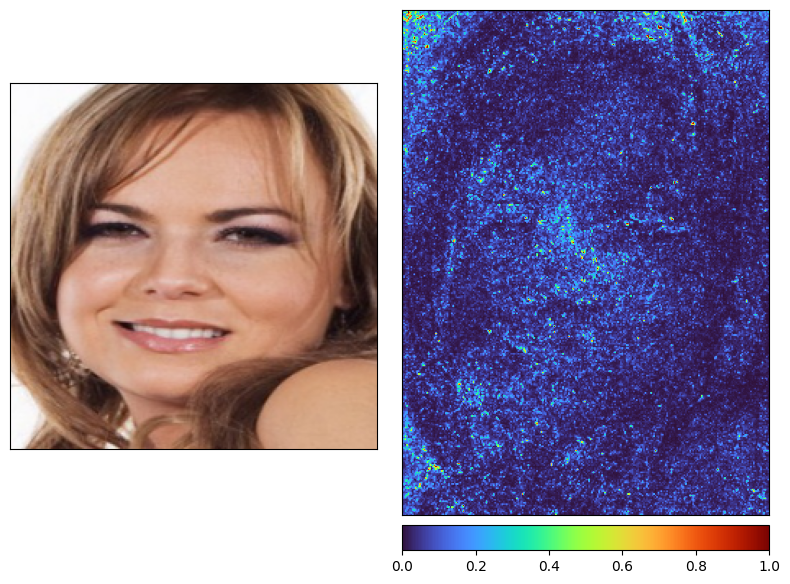

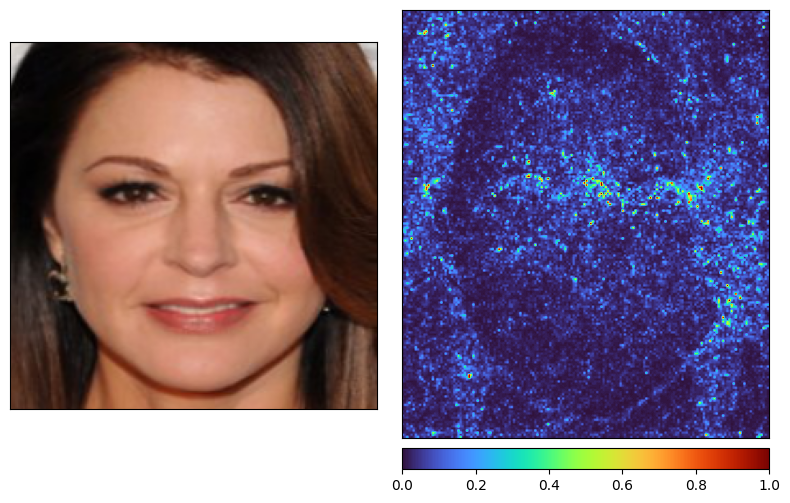

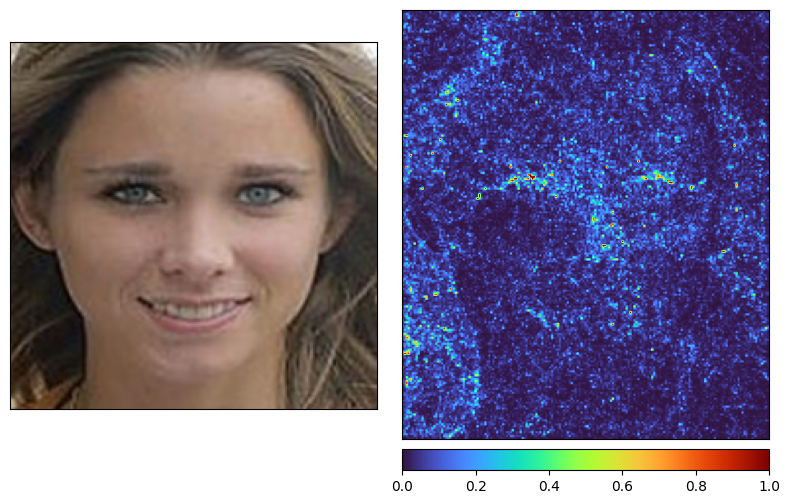

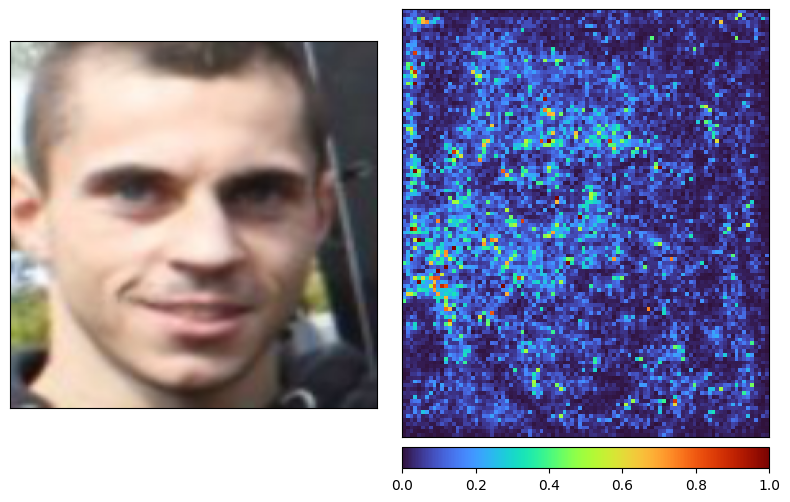

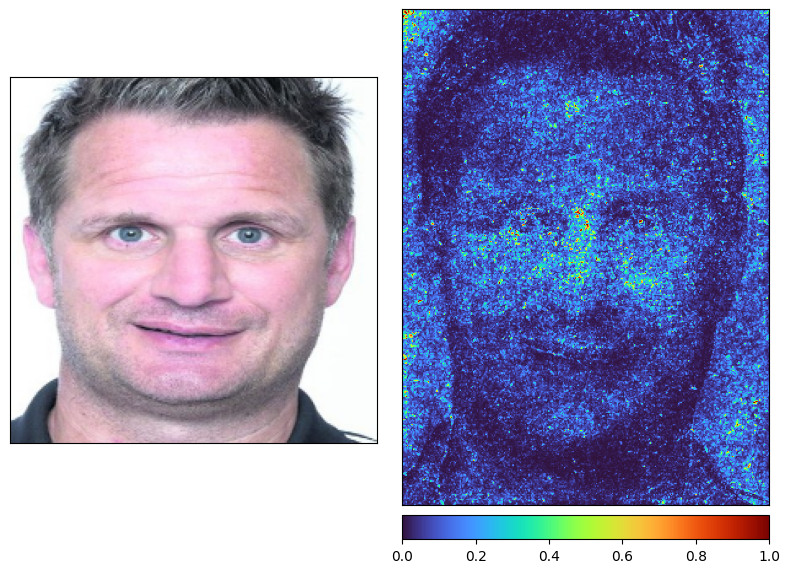

In [37]:
integrated_gradients = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(integrated_gradients)
for val_idx in straight_indexes[:5]: #range(1):
    image_path = val_images[val_idx]
    pred_label_idx = val_targets[val_idx]
    pil_image = Image.open(image_path)
    img = np.array(pil_image) 
    transformed_image = resize_transform(image=img)["image"]
    input = norm_transform(image=img)["image"].unsqueeze(0)
    attributions_ig_nt = noise_tunnel.attribute(
        input, nt_samples=5, nt_type="smoothgrad_sq", target=int(pred_label_idx)
    )
    _ = viz.visualize_image_attr_multiple(
        np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
        transformed_image,
        ["original_image", "heat_map"],
        ["all", "positive"],
        cmap="turbo",
        show_colorbar=True
    )